<a href="https://colab.research.google.com/github/rahiakela/advanced-natural-language-processing-with-tensorflow-2/blob/main/5-generating-text-with-rnn-and-gpt-2/01_generating_text_one_character_at_a_time.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Generating text – Overview

When your mobile phone completes a word as you type a message or when Gmail
suggests a short reply or completes a sentence as you reply to an email, a text
generation model is working in the background.

The Transformer architecture forms the basis of state-of-the-art text generation models. **BERT uses only the encoder part of the Transformer architecture.**

However, BERT, being bi-directional, is not suitable for the generation of text. A left-to-right (or right-to-left, depending on the language) language model built on the decoder part of the Transformer architecture is the foundation of text generation models today.

Text can be generated a character at a time or with words and sentences together.

Specifically, we will cover the following topics:

- Generating text with:
  - Character-based RNNs for generating news headlines and completing text messages
  - GPT-2 to generate full sentences

- Improving the quality of text generation using techniques such as:
  - Greedy search
  - Beam search
  - Top-K sampling

- Using advanced techniques such as learning rate annealing and
checkpointing to enable long training times
- Details of the Transformer decoder architecture
- Details of the GPT and GPT-2 models

A character-based approach for generating text is shown first. Such models can be quite useful for generating completions of a partially typed word in a sentence on a messaging platform, for example.



##Setup

In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import csv
import os
import datetime
import time
import matplotlib.pyplot as plt

tf.__version__

'2.5.0'

In [ ]:
######## GPU CONFIGS FOR RTX 2070 ###############
## Please ignore if not training on GPU       ##
## this is important for running CuDNN on GPU ##

tf.keras.backend.clear_session() #- for easy reset of notebook state

# chck if GPU can be seen by TF
tf.config.list_physical_devices('GPU')
#tf.debugging.set_log_device_placement(True)
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.experimental.set_memory_growth(gpus[0], True)
    tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)
###############################################

1 Physical GPUs, 1 Logical GPU


In [ ]:
%%capture

!wget https://github.com/PacktPublishing/Advanced-Natural-Language-Processing-with-TensorFlow-2/raw/master/chapter5-nlg-with-transformer-gpt/char-rnn/news-headlines.tsv

##Generating text – one character at a time

Text generation yields a window into whether deep learning models are learning
about the underlying structure of language. Text will be generated using two
different approaches.The first approach is an RNN-based model that generates a character at a time.

Text is tokenized into characters, which include capital and
small letters, punctuation symbols, and digits. There are 96 tokens in total. This
tokenization is an extreme example to test how much a model can learn about the
language structure.

##Data loading and pre-processing

For this particular example, we are going to use data from a constrained domain – a
set of news headlines. The hypothesis is that news headlines are usually short and
follow a particular structure. These headlines are usually a summary of an article and
contain a large number of proper nouns like names of companies and celebrities.

The first dataset is called the [News Aggregator dataset](https://archive.ics.uci.edu/ml/datasets/News+Aggregator).
This dataset has
over 420,000 news article titles, URLs, and other information.

The second dataset is a
set of over 200,000 news articles from The Huffington Post, called the [News Category dataset](https://www.kaggle.com/rmisra/news-category-dataset).

News article headlines from both datasets are extracted and compiled into one file.

Let's inspect the contents of the file to get a sense of the data:
$ head






In [ ]:
!head -5 news-headlines.tsv

There Were 2 Mass Shootings In Texas Last Week, But Only 1 On TV	there were 2 mass shootings in texas last week, but only 1 on tv
Will Smith Joins Diplo And Nicky Jam For The 2018 World Cup's Official Song	will smith joins diplo and nicky jam for the 2018 world cup's official song
Hugh Grant Marries For The First Time At Age 57	hugh grant marries for the first time at age 57
Jim Carrey Blasts 'Castrato' Adam Schiff And Democrats In New Artwork	jim carrey blasts 'castrato' adam schiff and democrats in new artwork
Julianna Margulies Uses Donald Trump Poop Bags To Pick Up After Her Dog	julianna margulies uses donald trump poop bags to pick up after her dog


## Data normalization and tokenization

This model uses a token per character. So, each letter, including
punctuation, numbers, and space, becomes a token. Three additional tokens are
added. These are:

- `<EOS>`: Denotes end of sentences
- `<UNK>`: it is common to replace out-of-vocabulary words with a special token
- `<PAD>`: This is a unique padding token used to pad all headlines to the
same length

To start, the tokenization function needs to be set up:

In [ ]:
chars = sorted(set("abcdefghijklmnopqrstuvwxyz0123456789 -,;.!?:’’’/\|_@#$%ˆ&*˜‘+-=()[]{}' ABCDEFGHIJKLMNOPQRSTUVWXYZ"))
chars = list(chars)

EOS = "<EOS>"
UNK = "<UNK>"
PAD = "<PAD>"  # need to move mask to '0'index for Embedding layer

chars.append(UNK)
chars.append(EOS)  # end of sentence

chars.insert(0, PAD)  # now padding should get index of 0

Once the token list is ready, methods need to be defined for converting characters to tokens and vice versa. 

Creating mapping is relatively straightforward:

In [ ]:
# Creating a mapping from unique characters to indices
char2index = {u: i for i, u in enumerate(chars)}
index2char = np.array(chars)

def char_index(ch):
  # takes a character and returns an index
  # if character is not in list, returns the unknown token
  if ch in chars:
    return char2index[ch]
  return char2index[UNK]

A maximum length of 75
characters is used for the headlines. If the headlines are shorter than this length,
they are padded. Any headlines longer than 75 characters are snipped. The <EOS>
token is appended to the end of every headline.

Let's set this up:

In [ ]:
data = []     # load into this list of lists
MAX_LEN = 75  # maximum length of a headline

with open("news-headlines.tsv", "r") as f:
  lines = csv.reader(f, delimiter="\t")
  for line in lines:
    headline = line[0]
    converted = [char_index(c) for c in headline[:-1]]  # convert to number

    if len(converted) >= MAX_LEN:
      converted = converted[0: MAX_LEN - 1]
      converted.append(char2index[EOS])
    else:
      converted.append(char2index[EOS])
      # add padding tokens
      remaining = MAX_LEN - len(converted)
      if remaining > 0:
        for i in range(remaining):
          converted.append(char2index[PAD])
    data.append(converted)
print("**** Data file loaded ****")

**** Data file loaded ****


You may be wondering about
the ground truth here for training as we only have a line of text. Since we want this
model to generate text, the objective can be reduced to predicting the next character
given a set of characters. 

Hence, a trick will be used to construct the ground truth
– we will just shift the input sequence by one character and set it as the expected
output.

This transformation is quite easy do with numpy:

In [ ]:
# now convert to numpy array
np_data = np.array(data)

# for training, we use one character shifted data
np_data_in = np_data[:, :-1]
np_data_out = np_data[:, 1:]

With this nifty trick, we have both inputs and expected outputs ready for training.

The final step is to convert it into tf.Data.DataSet for ease of batching and shuffling:

In [ ]:
# Create TF dataset
X = tf.data.Dataset.from_tensor_slices((np_data_in, np_data_out))

Now everything is ready to start training.

## Training the model

The model is quite simple. It has an embedding layer, followed by a GRU layer and a dense layer.

The size of the vocabulary, the number of RNN units, and the size of the embeddings are set up:

In [ ]:
# Length of the vocabulary in chars
vocab_size = len(chars)
# The embedding dimension
embedding_dim = 256
# Number of RNN units
rnn_units = 1024
# batch size
BATCH_SIZE = 256

With the batch size being defined, training data can be batched and ready for use by the model:

In [ ]:
# create tf.DataSet
x_train = X.shuffle(100000, reshuffle_each_iteration=True).batch(BATCH_SIZE, drop_remainder=True)

A convenience method to build models is defined like so:

In [ ]:
# define the model
def build_model(vocab_size, embedding_dim, rnn_units, batch_size):
  model = tf.keras.Sequential([
      tf.keras.layers.Embedding(vocab_size, embedding_dim, mask_zero=True, batch_input_shape=[batch_size, None]),
      tf.keras.layers.GRU(rnn_units, return_sequences=True, stateful=True, recurrent_initializer="glorot_uniform"),
      tf.keras.layers.Dropout(0.1),
      tf.keras.layers.Dense(vocab_size)                         
  ])

  return model

A model can be instantiated with this method:

In [ ]:
model = build_model(vocab_size=vocab_size, embedding_dim=embedding_dim, rnn_units=rnn_units, batch_size=BATCH_SIZE)

print("**** Model Instantiated ****")
print(model.summary())

**** Model Instantiated ****
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (256, None, 256)          24576     
_________________________________________________________________
gru (GRU)                    (256, None, 1024)         3938304   
_________________________________________________________________
dropout (Dropout)            (256, None, 1024)         0         
_________________________________________________________________
dense (Dense)                (256, None, 96)           98400     
Total params: 4,061,280
Trainable params: 4,061,280
Non-trainable params: 0
_________________________________________________________________
None


There are just over 4 million trainable parameters in this model. 

The Adam optimizer, with a sparse categorical loss function, is used for training this model:

In [ ]:
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer="adam", loss=loss)

Since training is potentially going to take a long time, we need to set up checkpoints along with the training. If there is any problem in training and training stops, these checkpoints can be used to restart the training from the last saved checkpoint. 

A directory is created using the current timestamp for saving these checkpoints:

In [ ]:
# Setup checkpoints

# dynamically build folder names
dt = datetime.datetime.today().strftime("%Y-%b-%d-%H-%M-%S")

# Directory where the checkpoints will be saved
checkpoint_dir = "./training_checkpoints/" + dt
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_prefix, save_weights_only=True)

A custom callback that saves checkpoints during training is passed to the `model.fit()` function to be called at the end of every epoch.

In [ ]:
print("**** Start Training ****")
EPOCHS = 25
start = time.time()

history = model.fit(x_train, epochs=EPOCHS, callbacks=[checkpoint_callback])

print("**** End Training ****")
print("Training time: ", time.time()- start)

**** Start Training ****
Epoch 1/25
2434/2434 [==============================] - 319s 128ms/step - loss: 1.2671
Epoch 2/25
2434/2434 [==============================] - 316s 130ms/step - loss: 0.9807
Epoch 3/25
2434/2434 [==============================] - 316s 130ms/step - loss: 0.9376
Epoch 4/25
2434/2434 [==============================] - 316s 130ms/step - loss: 0.9198
Epoch 5/25
2434/2434 [==============================] - 316s 130ms/step - loss: 0.9103
Epoch 6/25
2434/2434 [==============================] - 316s 130ms/step - loss: 0.9050
Epoch 7/25
2434/2434 [==============================] - 316s 130ms/step - loss: 0.9019
Epoch 8/25
2434/2434 [==============================] - 317s 130ms/step - loss: 0.8995
Epoch 9/25
2434/2434 [==============================] - 317s 130ms/step - loss: 0.8986
Epoch 10/25
2434/2434 [==============================] - 317s 130ms/step - loss: 0.8984
Epoch 11/25
2434/2434 [==============================] - 316s 130ms/step - loss: 0.8987
Epoch 12/25
2434

The final piece of code uses the history to plot the loss and
save it as a PNG file in the same directory:

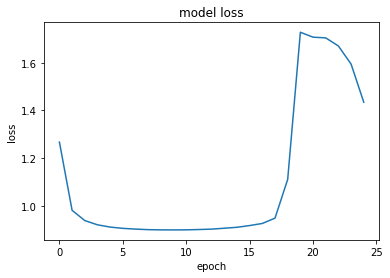

In [ ]:
# Plot accuracies
lossplot = "loss-" + dt + ".png"
plt.plot(history.history['loss'])
plt.title('model loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

As we can see, the loss decreases to a point and then shoots up. The standard
expectation is that loss would monotonically decrease as the model was trained for more epochs.

In the case shown above, the loss suddenly shoots up. In other cases,
you may observe a NaN, or Not-A-Number, error. NaNs result from the exploding
gradient problem during backpropagation through RNNs.

The gradient direction causes weights to grow very large quickly and overflow, resulting in NaNs.

The primary reason behind these occurrences is gradient descent overshooting the
minima and starting to climb the slope before reducing again. This happens when
the steps gradient descent is taking are too large. Another way to prevent the NaN issue is gradient clipping where gradients are clipped to an absolute maximum, preventing loss from exploding.

**In the RNN model, a scheme needs to be used that reduces the learning rate over time. Reducing the learning rate over epochs
reduces the chances for gradient descent to overshoot the minima. This technique
of reducing the learning rate over time is called learning rate annealing or learning rate decay.**



##Implementing learning rate decay

There are two ways to implement learning rate decay in TensorFlow. The first way
is to use one of the prebuilt schedulers that are part of the
`tf.keras.optimizers.schedulers` package and use a configured instance with the optimizer.

An example of a prebuilt scheduler is InverseTimeDecay.

In [ ]:
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
    0.001,          # initial learning rate
    decay_steps=STEPS_PER_EPOCH*(EPOCHS/10),
    decay_rate=2,
    staircase=False
)

The
number of steps per epoch can be calculated by dividing the number of training
examples by batch size. The number of decay steps determines how the learning
rate is reduced. The equation used to compute the learning rate is:

$$
new\_rate = \frac{initial\_rate}{1 + decay\_rate * (\frac{step}{decay\_step})} 
$$

After being set up, all this function needs is the step number for computing the new learning rate. Once the schedule is set up, it can be passed to the optimizer:

In [ ]:
optimizer = tf.keras.optimizers.Adam(lr_schedule)

That's it! The rest of the training loop code is unchanged. 

However, this learning rate scheduler starts reducing the learning rate from the first epoch itself. A lower learning rate increases the amount of training time. Ideally, we would keep the learning rate unchanged for the first few epochs and then reduce it.

Looking at plot above, the learning rate is probably effective until about the
tenth epoch.

BERT also uses learning rate warmup before learning rate decay.
Learning rate warmup generally refers to increasing the learning rate for a few
epochs. BERT was trained for 1,000,000 steps, which roughly translates to 40 epochs.
For the first 10,000 steps, the learning rate was increased, and then it was linearly
decayed. Implementing such a learning rate schedule is better accomplished by a
custom callback.

Custom callbacks in TensorFlow enable the execution of custom logic at various
points during training and inference. We saw an example of a prebuilt callback that saves checkpoints during training. 

A custom callback provides hooks that enable
desired logic that can be executed at various points during training. This main
step is to define a subclass of `tf.keras.callbacks.Callback`. Then, one or more of the following functions can be implemented to hook onto the events exposed by TensorFlow:

- `on_[train,test,predict]_begin / on_[train,test,predict]_end`: This
callback happens at the start of training or the end of the training.

- `on_[train,test,predict]_batch_begin / on_[train,test,predict] _batch_
end`: These callbacks happen when training for a specific batch starts or ends.

- `on_epoch_begin / on_epoch_end`: This is a training-specific function called at the start or end of an epoch.

We will implement a callback for the start of the epoch that adjusts that epoch's
learning rate. Our implementation will keep the learning rate constant for a
configurable number of initial epochs and then reduce the learning rate in a fashion
similar to the inverse time decay function.

<img src='https://github.com/rahiakela/advanced-natural-language-processing-with-tensorflow-2/blob/main/5-generating-text-with-rnn-and-gpt-2/images/1.png?raw=1' width='800'/>

First, a subclass is created with the function defined in it. The best place to put this, is just around the checkpoint callback, before the start of training.

In [ ]:
# Custom Callback for Learning Rate Decay
class LearningRateScheduler(tf.keras.callbacks.Callback):
  """Learning rate scheduler which decays the learning rate"""

  def __init__(self, init_lr, decay, steps, start_epoch):
    super().__init__()
    self.init_learning_rate = init_lr   #initial learning rate
    self.decay = decay                  # how sharply to decay
    self.steps = steps                  # total number of steps of decay
    self.start_epoch = start_epoch      # which epoch to start decaying

  def on_epoch_begin(self, epoch, logs=None):

    if not hasattr(self.model.optimizer, "lr"):
      raise ValueError('Optimizer must have a "lr" attribute.')
    # Get the current learning rate from model's optimizer.
    lr = float(tf.keras.backend.get_value(self.model.optimizer.lr))

    if (epoch >= self.start_epoch):
      # Call schedule function to get the scheduled learning rate.
      scheduled_lr = self.init_learning_rate / (1 + self.decay * (epoch / self.steps))
      # Set the value back to the optimizer before this epoch starts
      tf.keras.backend.set_value(self.model.optimizer.lr, scheduled_lr)
      print("\nEpoch %05d: Learning rate is %6.8f." % (epoch, scheduled_lr))

Using this callback in the training loop requires the instantiation of the callback. The following parameters are set while instantiating the callback:

- The initial learning rate is set to 0.001.
- The decay rate is set to 4. Please feel free to play around with different
settings.
- The number of steps is set to the number of epochs. The model is trained for
150 epochs.
- Learning rate decay should start after epoch 10, so the start epoch is set to 10.

The training loop is updated to include the callback like so:

In [ ]:
print("**** Start Training ****")

EPOCHS = 150
lr_decay = LearningRateScheduler(0.001, 4., EPOCHS, 10)

start = time.time()

history = model.fit(x_train, epochs=EPOCHS, callbacks=[checkpoint_callback, lr_decay])

print("**** End Training ****")
print("Training time: ", time.time()- start)

print("Checkpoint directory: ", checkpoint_dir)

Now, the model is ready to be trained. Training 150 epochs took over 10 hours on the GPU-capable machine.


In [ ]:
# Plot accuracies
lossplot = "loss-" + dt + ".png"
plt.plot(history.history['loss'])
plt.title('model loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

The loss drops very fast for the first few epochs before plateauing
near epoch 10. Learning rate decay kicks in at that point, and the loss starts to fall again.

Training this model took much time and advanced tricks like learning rate decay to train.